# STH co-infection model

In [1]:
using Distributions #Package contaning negative binomial distribution

### Global parameters

In [2]:
const ts = 1/73 #time step in years; 5 days
const halflife = 8.1/365 * ts #halflife of immunity in hosts in days
const av_age = 18.2 #Initial average age in years in population - used very roughly
const pc_dr = 8/1000 * ts #per capita death rate
const stool_samp = 0.054 #Stool sample used in measuring egg deposition

0.054

Age specific death rates
Source: Table 7 in http://www.statistics.gov.lk/PopHouSat/Life%20Table%20Report%202001_7th%20July%202009.pdf

In [3]:
age_specific_death_rates = vcat(
        repeat([0.00045 * ts], inner = 5),
        repeat([0.00078 * ts], inner = 10),
        repeat([0.00320 * ts], inner = 15),
        repeat([0.00429 * ts], inner = 10),
        repeat([0.00890 * ts], inner = 10),
        repeat([0.01946 * ts], inner = 10),
        repeat([0.04245 * ts], inner = 10),
        repeat([0.09133 * ts], inner = 10),
        repeat([0.22017 * ts], inner = 10),
        repeat([1],inner = 100))
# ### Worm species specific parameters
# Defining a data structure with parameter values that are specific to worm species, which will all be of the same type (class)
# Can access elements in the structure using '.', e.g `N_a.b`
# T means type, e.g. Int, Float64.
# The struct is mutable so that parameters can vary if necessary
mutable struct Par{T}
  b                    ::T   # 1.rate of exposure per day - has to be v v low
  Imme_activation      ::T   # 2.to fit - activation of immunity per worm
  Immf_activation      ::T   # 3.as above but for anti fecundity immunity
  WfN                  ::T   # 4.max eggs per day per female worm
  mu_le                ::T   # 5.death rate of early larvae per day
  mu_ll                ::T   # 6.death rate of late larvae per day
  mu_adults            ::T   # 7.death rate of adult worms per day
  M_le                 ::T   # 8.rate of maturation of early larvae per day
  M_ll                 ::T   # 9.rate of maturation of late larvae per day
  pool_egg_loss        ::T   # 10.rate of loss of eggs from field per day
  pool_egg_maturation  ::T   # 11.rate of maturation of eggs in field oer day
  pool_infectives_loss ::T   # 12.rate of loss of infective larvae from field per day
  dens_effect          ::T   # 13.density dependent effect on per worm fecundity
  k                    ::T   # 14.k of negative binomial distribution (mean, k)
  weightings           ::T   # 15.relative weight of worms
  est_modulation       ::T   # 16.modulation of antiestablishment immunity
  fec_modulation       ::T   # 17.modulation of antifecundity immunity
  init_mean            ::T   # 18.mean of initial distribution of worms in pop.
end

Inputting parameters for each species

In [4]:
N_a = Par{Float64}(
    5e-10,
    0.00, 0.00, #1,2,3
    20000 * 365 * ts, 0.067 * 365 * ts, 0.00182 * 365 * ts, #4,5,6
    0.00182 * 365 * ts, 0.07 * 365 * ts, 0.0467 * 365 * ts, #7,8,9
    0.011 * 365 * ts, 0.11 * 365 * ts, 0.15 * 365 * ts, #10,11,12
    0.019, 0.27, 0.037, 0, 0, 16.34) #13,14,15,16,17,18


A_l = Par{Float64}(
    01e-11,
    0.00, 0.00, #1,2,3
    200000 * 365 * ts, 0.067 * 365 * ts, 0.00183 * 365 * ts, #4,5,6
    0.00183 * 365 * ts, 0.10 * 365 * ts, 0.0714 * 365 * ts, #7,8,9
    0.0085 * 365 * ts, 0.0286 * 365 * ts, 0.03 * 365 * ts, #10,11,12
    0.00425, 0.34, 1, 0, 0, 434) #13,14,15,16,17,18

T_t = Par{Float64}(
    01e-10,
    0.00, 0.00, #1,2,3
    20000 * 365 * ts, 1, 0.00182 * 365 * ts, #4,5,6
    0.00182 * 365 * ts, min(0.4 * 365 * ts, 1), 0.0133 * 365 * ts, #7,8,9
    0.00192 * 365 * ts, 0.0286 * 365 * ts, 0.05 * 365 * ts, #10,11,12
    0.001, 0.21, 0.0148, 0, 0, 38.79) #13,14,15,16,17,18
# Can keep these three Pars structs in an array, accessing as SpPars[1] etc
SpPars = [N_a, A_l, T_t]

3-element Array{##728.Par{Float64},1}:
 ##728.Par{Float64}(5.0e-10, 0.0, 0.0, 100000.0, 0.335, 0.0091, 0.0091, 0.35, 0.2335, 0.055, 0.55, 0.75, 0.019, 0.27, 0.037, 0.0, 0.0, 16.34)
 ##728.Par{Float64}(1.0e-11, 0.0, 0.0, 1.0e6, 0.335, 0.00915, 0.00915, 0.5, 0.357, 0.0425, 0.143, 0.15, 0.00425, 0.34, 1.0, 0.0, 0.0, 434.0) 
 ##728.Par{Float64}(1.0e-10, 0.0, 0.0, 100000.0, 1.0, 0.0091, 0.0091, 1.0, 0.0665, 0.0096, 0.143, 0.25, 0.001, 0.21, 0.0148, 0.0, 0.0, 38.79)

### Host infections data structures

Each host has infections attributes per species in a data structure:

In [5]:
struct Infection{T}
    Imme    ::T #Anti-establishment immunity strength
    Immf    ::T #Anti-fecundity immunity strength
    PEL     ::T #Pre establishment larvae
    EL      ::T #Established larvae
    AW      ::T #Adult worms
    EOut    ::T #Egg output
end

Define a method so that we can easily make an empty structure.

In [6]:
Infection{T}() where T = Infection{T}(0,0,0,0,0,0)

### Pool attributes data structre

In [7]:
struct Soil{T}
    PIS ::T #Pre-infective stages
    IS  ::T #Infective stages
end

Soil{T}() where T = Soil{T}(0,0)

### Model functions ######

#### Update infections
Arguments are: individual, worm burden, infective stages in pool, halflife, parameters.
We assume everything is happening sequentially rather than simultaneously - therefore:
- Imme and Immf calculation uses WB from the previous time step and are only calculated once
- New eggs uses this time step's adult worms even though Imme and Immf are using *last* timestep's WB.

In [8]:
function update_Infection(i, WB, IS, halflife, p, risk)
    #New infections
    #mean = 5 #fixed acquisition
    mean = p.b * IS * risk#Non fixed acquisition
    #mean = 5 * risk #gamma risk

    if mean > 0
        exposure = mean
        #exposure = float(rand(Poisson(mean)))
        #exposure = float(rand(NegativeBinomial(1, (mean/(mean+p.k)))))
    else
        exposure = 0.0
    end

    #New pre-establishment larvae
    newPEL = ((1-p.mu_le) * i.PEL) + exposure
    PEL = newPEL * (1-p.M_le)
    @assert PEL >= 0 "PEL < 0"

    #Anti establishment immunity
    activation = newPEL * p.Imme_activation
    if p.est_modulation > 0
      modulation = exp(-(p.est_modulation * WB))
    else
      modulation = 1
    end
    Imme = ((0.5^(1/halflife) * i.Imme) + activation) * modulation

    #New established larvae
    newEL = ((1-p.mu_ll) * i.EL) + (p.M_le * newPEL * exp(-Imme))
    EL = newEL * (1-p.M_ll)
    @assert EL >= 0 "EL < 0"

    #Anti fecundity immunity
    activation = newEL * p.Immf_activation
    if p.fec_modulation > 0
      modulation = exp(-(p.fec_modulation * WB))
    else
      modulation = 1
    end
    Immf = ((0.5^(1/halflife) * i.Immf) + activation) * modulation

    #New adults
    AW = float(rand(Poisson(((1-p.mu_adults) * i.AW) + (p.M_ll * newEL))))
    #AW = ((1-p.mu_adults) * i.AW) + (p.M_ll * newEL))
    @assert AW >= 0 "AW < 0"

    #New eggs
    modulation = exp(-(Immf + (p.dens_effect * AW/2)))
    EOut = AW/2 * p.WfN * modulation

    Infection{Float64}(Imme, Immf, PEL, EL, AW, EOut)
end

update_Infection (generic function with 1 method)

#### Calculate worm burdens (WB)

In [9]:
function update_WBs(pop, pars, n_hosts)
  [sum([x.AW for x in pop[i,:]] .* [p.weightings for p in pars]) for i in 1:n_hosts]
end

update_WBs (generic function with 1 method)

#### Deposit eggs in soil
Arguments: soil, population of infections, parameters

In [10]:
function update_pool(S, pop, p)
    Eggs = sum([x.EOut for x in pop])
    PIS = ((1 - (p.pool_egg_loss + p.pool_egg_maturation)) * S.PIS) + Eggs
    IS = ((1-p.pool_infectives_loss) * S.IS) + (p.pool_egg_maturation * S.PIS)
    #IS = ((1-p.pool_infectives_loss) * (1 - (p.b * length(pop[:,1]))) * S.IS)
              + (p.pool_egg_maturation * S.PIS)

    Soil{Float64}(PIS, IS)
end

update_pool (generic function with 1 method)

#### Birth and death process

Select all individuals over 80 years old and randomly  select from the rest of
the population - reset ages and infections so population size remains constant

In [11]:
function get_age_index(age) ifelse(age <= 0.5, 1, Int(round(age))) end

function reset_inds_sys(population, ages, risk, death_rates, pars)
  for i = 1:length(ages)
    #@assert ages[i] < 100 "age > 100"
    if rand(Binomial(1, death_rates[get_age_index(ages[i])])) == 1
      population[i, 1:3] .= Infection{Float64}()
      ages[i] = 0
      risk[i, 1:3] = [rand(Gamma(p.k, 1/p.k)) for p in pars]
    end
  end
  return population, ages, risk
end

function update_ages(ages, ts)
    [a += ts for a in ages]
end

update_ages (generic function with 1 method)

### Set up and model run functions

In [12]:
function initworms(init_mean, k)
  if init_mean == 0
    Infection{Float64}()
  else
    Infection{Float64}(0, 0, 0, 0, float(rand(NegativeBinomial(k, (k)/(init_mean + k)))), 0)
  end
end

function SystemSetUp(n_hosts, pars, av_age)
    #Initialise ages, assume exponential type population structure
    ages = [rand(Uniform(0, 80)) for i in 1:n_hosts]

    #New and exciting: gamma distributed risk
    risk = [rand(Gamma(p.k, 1/p.k)) for i in 1:n_hosts, p in pars]

    #Initialise pool with eggs and infective stages
    Pool = [Soil{Float64}(100, 100) for sp in 1:3]

    #Initialise worms with n. binom draw for adults
    pop_infections = [initworms(p.init_mean, p.k) for i in 1:n_hosts, p in pars]

    #Initialise worms burdens based on initial adult burdens
    WBs = update_WBs(pop_infections, pars, n_hosts)
    return ages, risk, Pool, pop_infections, WBs
end


function run_mod(n_hosts, pars, ts, halflife, pop_infections, Pool, ages, WBs, death_rates, risk)

    #Update ages and remove some individuals
    ages = update_ages(ages, ts)
    pop_infections, ages, risk = reset_inds_sys(pop_infections, ages, risk, death_rates, pars)

    #Species specific calculations
    for sp in 1:3

        #Per host calculations
        for i in 1:n_hosts
            pop_infections[i, sp] = update_Infection(pop_infections[i, sp], WBs[i],
                                        Pool[sp].IS, halflife, SpPars[sp], risk[i, sp])
        end

        #Update pool
        Pool[sp] = update_pool(Pool[sp], pop_infections[:, sp], SpPars[sp])
    end

    #Update worm burdens
    WBs = update_WBs(pop_infections, SpPars, n_hosts)

    return ages, pop_infections, Pool, WBs
end

run_mod (generic function with 1 method)

Note on order in run_mod function: WB happens outside of the species and host
loop because it needs information from all species in the whole population

In [13]:
function main(n_runs, n_hosts; pars = SpPars, av_age = 18.2, ts_ = ts, halflife_ = halflife,
              death_rates = age_specific_death_rates,
              record_run = 0, record_final = 1)

  #Set arrays up
  ages, risk, Pool, pop_infections, WBs = SystemSetUp(n_hosts, pars, av_age)

  #For storing summary statistics
  stages = [:Imme, :Immf, :PEL, :EL, :AW, :EOut, :prev, :soil]
  if record_run > 0
    run_record = Dict(s => zeros(Float64, n_runs, 3) for s in stages)
  else
    run_record = 0
  end

  #Loop through the runs
  for r in 1:n_runs
    ages, pop_infections, Pool, WBs = run_mod(n_hosts, pars, ts_, halflife_,
        pop_infections, Pool, ages, WBs, death_rates, risk)

    #Get records for whole run
    if record_run > 0
      for sp in 1:3
        for s in 1:6
          run_record[stages[s]][r,sp] = mean([getfield(x, s) for x in pop_infections[:,sp]])
        end
        run_record[stages[7]][r, sp] = count(i -> i > 0.0, x.AW for x in pop_infections[:,sp])/n_hosts
        run_record[stages[8]][r,sp] = Pool[sp].IS
      end
    end

  end

  #Get final distributions
  if record_final > 0
    final_record = Dict(s => zeros(Float64, n_hosts, 3) for s in stages[1:6])
    for sp in 1:3
      for s in 1:6
        final_record[stages[s]][:,sp] = [getfield(x, s) for x in pop_infections[:,sp]]
      end
    end
  else
    final_record = 0
  end

  return run_record, final_record, ages, pop_infections
end

main (generic function with 1 method)

## Example run

In [14]:
@time run_record, final_record, ages, pop_infections = main(1000, 2000, record_run = 1)

  6.591756 seconds (148.38 M allocations: 7.799 GiB, 19.17% gc time)


(Dict(:soil=>[80.0 99.3 89.3; 5.02901e8 1.08165e10 4.9125e8; … ; 1.25776e9 3.46117e11 8.02519e10; 1.25417e9 3.4606e11 8.02869e10],:Immf=>[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0],:PEL=>[3.0329e-8 5.45904e-10 0.0; 3.73729e-8 7.23596e-10 0.0; … ; 0.680506 2.76866 0.0; 0.680554 2.76949 0.0],:AW=>[16.4605 420.784 37.5915; 16.261 416.904 37.1275; … ; 38.061 290.43 763.192; 38.093 289.918 764.184],:EOut=>[4.57182e5 3.78198e7 1.71766e6; 4.51259e5 3.77357e7 1.69799e6; … ; 5.1556e5 3.36492e7 1.07492e7; 517179.0 3.35602e7 1.07547e7],:prev=>[0.641 0.8915 0.6425; 0.6085 0.879 0.62; … ; 0.5045 0.7545 0.6905; 0.4985 0.7615 0.6895],:EL=>[1.25177e-8 3.51016e-10 9.01236e-9; 2.49325e-8 6.8891e-10 1.63845e-8; … ; 1.16719 4.89875 100.577; 1.16739 4.90186 100.641],:Imme=>[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]), Dict(:Immf=>[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0],:PEL=>[0.525923 0.00429936 0.0; 0.0124343 1.32474 0.0; … ; 0.0461921 11.9921 0.0; 0.350556 0.549

### Plot output

In [15]:
using Plots

Plots of each time step.
y1 = Na, y2 = Al, y3 = Tt

Pre-established larvae

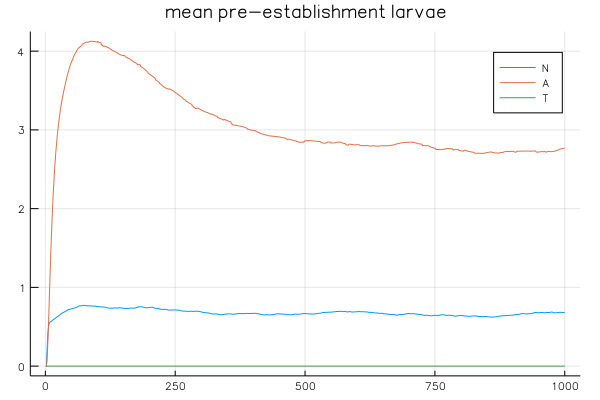

In [16]:
plot(1:1000, run_record[:PEL][1:1000,:], title = "mean pre-establishment larvae", label = ["N", "A", "T"])

Established larvae

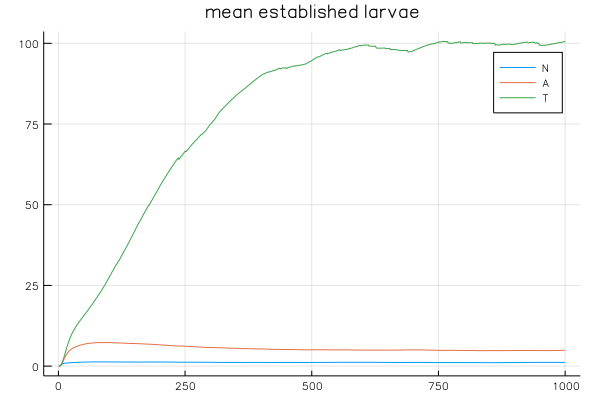

In [17]:
plot(1:1000, run_record[:EL][1:1000,:], title = "mean established larvae", label = ["N", "A", "T"])

Adult worms - the poisson draw now happens to as worms enter the adult phase

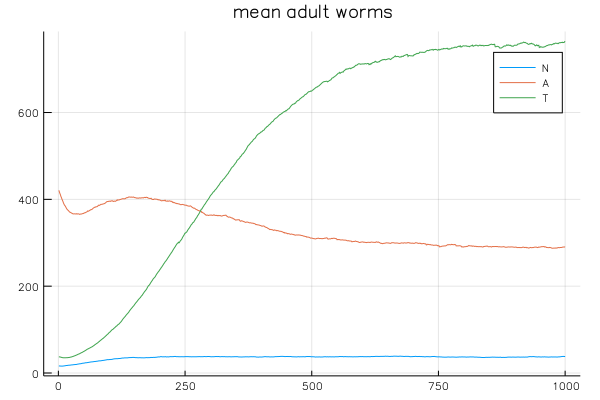

In [18]:
plot(1:1000, run_record[:AW][1:1000,:], title = "mean adult worms", label = ["N", "A", "T"])

All eggs per host

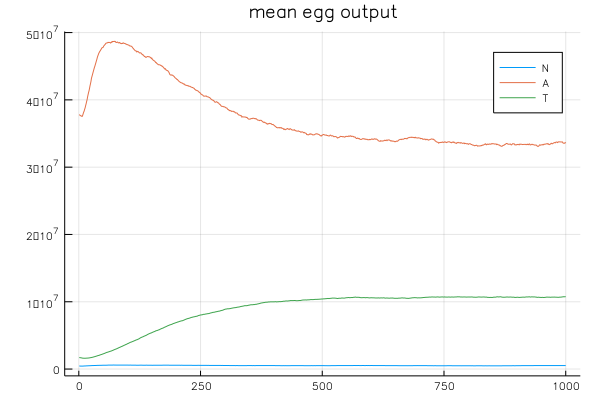

In [19]:
plot(1:1000, run_record[:EOut][1:1000,:], title = "mean egg output", label = ["N", "A", "T"])

Prevalence - positives numbers of adult worms

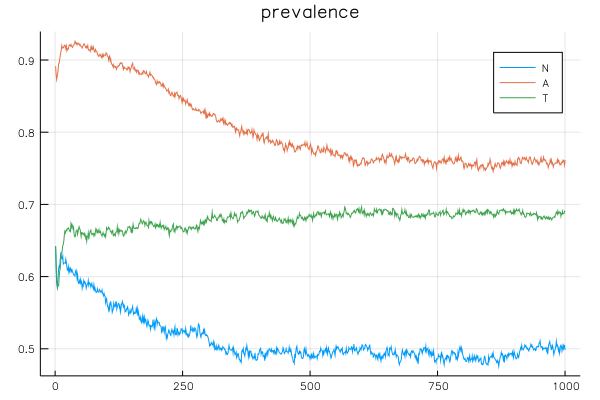

In [20]:
plot(1:1000, run_record[:prev][1:1000,:], title = "prevalence", label = ["N", "A", "T"])

Infective stages in the soil, absolute numbers

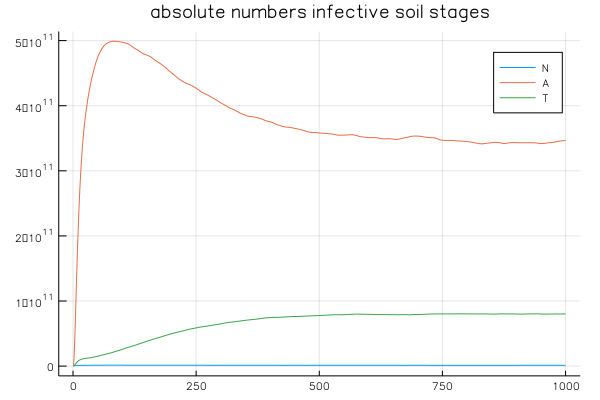

In [21]:
plot(1:1000, run_record[:soil][1:1000,:], title = "absolute numbers infective soil stages", label = ["N", "A", "T"])

Histograms of final time step (should be stedy) - reassuringly these are all negative binomial looking.
Printed below on the notebook is the histogram of Trichuris adult worms in the population
at the end of the simulation.

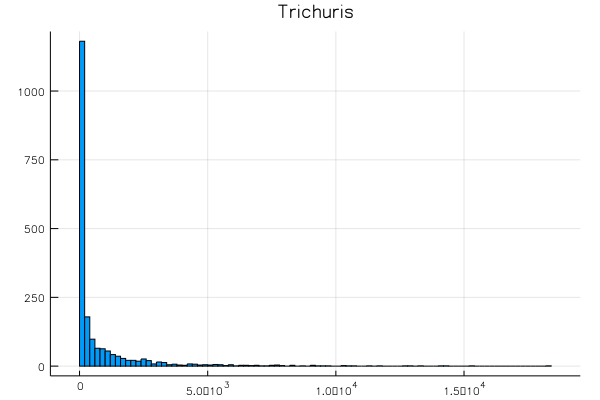

In [22]:
histogram(final_record[:AW][:,1], legend = false, title = "N.americanus")
histogram(final_record[:AW][:,2], legend = false, title = "Ascaris")
histogram(final_record[:AW][:,3], legend = false, title = "Trichuris")

The histogram of the eggs per individual at the end of the simulation is not as nicely negative binomial.

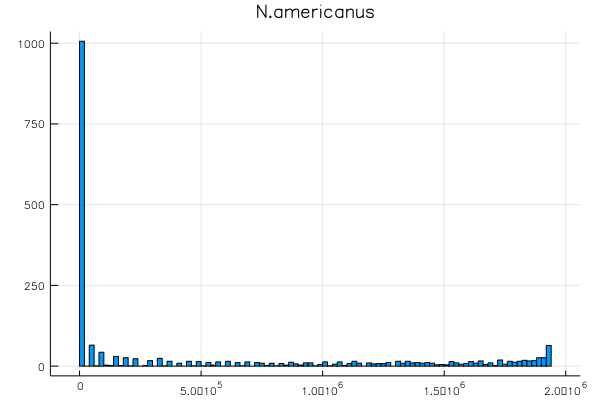

In [23]:
histogram(final_record[:EOut][:,2], legend = false, title = "Ascaris")
histogram(final_record[:EOut][:,3], legend = false, title = "Trichuris")
histogram(final_record[:EOut][:,1], bins = 100, legend = false, title = "N.americanus")

I am not sure what is caugin this -
it may be do do with the birth-death process, which is not maintaining an exponential distribution.
To demonstrate, a histogram of ages in the population at the end of the simulation.

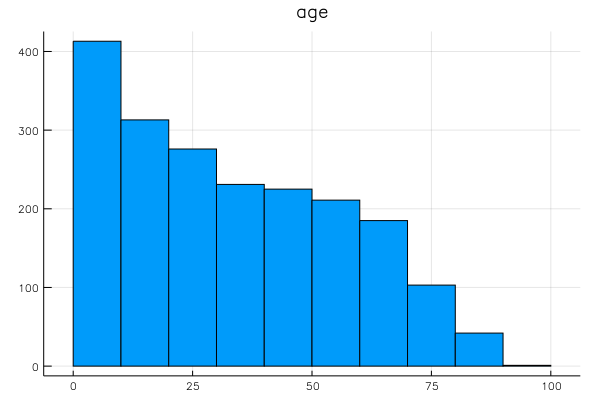

In [24]:
histogram(ages, legend = false, title = "age")

It may also be to do with the density dependent process.
A quick test of what happens if there is density dependence in a Poisson process:

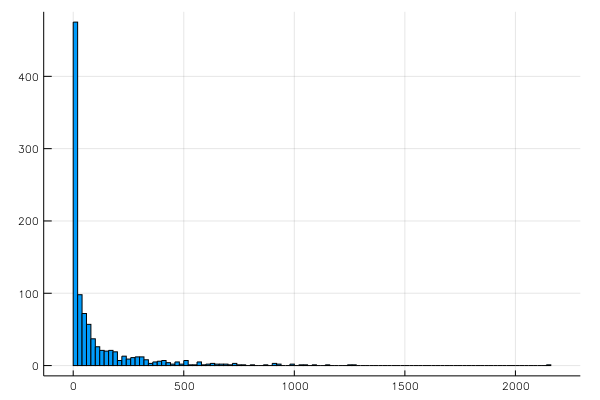

In [25]:
risk = rand(Gamma(0.3, 1/0.3), 1000)
acquisition = map(i -> rand(Poisson(100 * i)), risk)
histogram(acquisition, legend = false)

Now we try the density dependent component

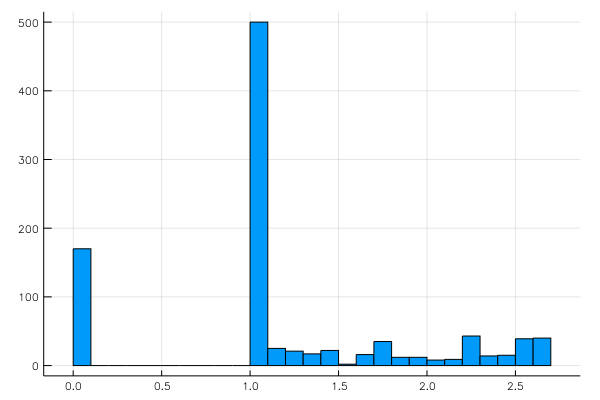

In [26]:
acquisition_density_dependent = map(i -> i^exp(-(i * 0.1)), acquisition)
histogram(acquisition_density_dependent, legend = false)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*